In [82]:
import pandas as pd
import xgboost as xgp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # Interactive Data Visualization
import sys
sys.path.insert(0, '~/flask_github/fastapi/app')

from db import call_db_json

In [108]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
volume_df = pd.read_csv('../data_mine/volume_data.csv')
facility_df = pd.read_csv('../data/facility_data.csv')
to_drop_cols =['Unnamed: 0', 'facility_id', 'operation_sequence', 'total_quantity_complete', 'facility_description', 'operation_status', 'total_quantity_scrap', 'start', 'fin', 'B0010', 'C0010', 'D0010', 'facilities', 'product_family', 'product_model']
substrings = ['GL', 'J', 'K']    
for i in volume_df.columns:    
    if any(sub in i for sub in substrings):
        to_drop_cols.append(i)
volume_df.head()

order_number  Unnamed: 0  operation_sequence facility_id  \
0      M875305        1861                  90       F0010   
1      M919255        2507                  90       F0010   
2      M914207        3370                  90       F0010   
3      M899965        7847                 110       K0020   
4      M876923        9215                  90       F0010   

   total_quantity_complete  total_quantity_scrap   facility_description  \
0                        1                     0  WASHING & WIPING RAIL   
1                        4                     0  WASHING & WIPING RAIL   
2                        5                     0  WASHING & WIPING RAIL   
3                        5                     0   WRAPPING & PACKAGING   
4                        2                     0  WASHING & WIPING RAIL   

   operation_status                      start                        fin  \
0                40  2021-10-08 13:54:28+00:00  2021-11-29 15:37:54+00:00   
1                40  2021-10-08 13:22:07+00:00  2021-11-29 15:38:08+00:00   
2                40  2022-03-04 16:18:11+00:00  2022-04-08 20:37:29+00:00   
3                40  2021-10-08 14:09:09+00:00  2021-11-29 16:28:46+00:00   
4                40  2021-08-24 17:23:23+00:00  2021-11-05 12:25:59+00:00   

       B0021      F0010  B0010     K0010     K0020     B0012      B0020  \
0   805200.0  1001059.0    NaN  249064.0   76910.0  538302.0  3566930.0   
1   805200.0  1027629.0    NaN  245304.0  119006.0  446962.0  3566930.0   
2  3369920.0   566756.0    NaN  245505.0   83880.0  804416.0  1936270.0   
3   805200.0   871901.0    NaN  358440.0  106910.0  750440.0  3566930.0   
4        NaN        NaN    NaN       NaN       NaN       NaN        NaN   

      B0040      B0070      B0080     C0040      C0060     C0080  C0010  \
0  546714.0  1210318.0  1129798.0   86260.0  2359038.9  959316.0    NaN   
1  546714.0  1210318.0  1144898.0   86260.0  2373938.9  937636.0    NaN   
2  228642.0   296000.0   259606.0  116100.0  3261235.0  919530.0    NaN   
3  546714.0  1210318.0  1129798.0   86260.0  2359038.9  949886.0    NaN   
4       NaN        NaN        NaN       NaN        NaN       NaN    NaN   

      C0020     J0020   H0020  D0010   H0070  H0010    D0020     H0030  C0050  \
0  362858.0  132906.0     NaN    NaN  3168.0    NaN  15918.0  154410.0    NaN   
1  358378.0  139186.0     NaN    NaN  3168.0    NaN  15918.0  154410.0    NaN   
2  807733.0  157952.0  3400.0    NaN     NaN    NaN  23910.0  508946.0    NaN   
3  362858.0  132906.0     NaN    NaN  3168.0    NaN  15000.0  154410.0    NaN   
4       NaN       NaN     NaN    NaN     NaN    NaN      NaN       NaN    NaN   

     C0100   C0110  J0025      B0025     C0075      B0060      B0090  \
0      NaN  2080.0    NaN  6976839.0  797478.0  6181614.0   203680.0   
1      NaN  2080.0    NaN  6976839.0  808471.0  6257614.0   127680.0   
2  36220.0     NaN    NaN  2690400.0  970874.0  5073992.0  1087700.0   
3      NaN  2080.0    NaN  6976839.0  788178.0  6181614.0   203680.0   
4      NaN     NaN    NaN        NaN       NaN        NaN        NaN   

      C0090     B0030    C0070    K0011   H0046    H0050     B0050    H0060  \
0  591260.0  639420.0  48040.0  60720.0  3168.0   3320.0  624700.0   4144.0   
1  596761.0  639420.0  48040.0  44880.0  3168.0   3320.0  624700.0   4144.0   
2  286362.0  225600.0  39600.0  30720.0  3040.0  24284.0  303000.0  24880.0   
3  605170.0  639420.0  48040.0  60720.0  3168.0   3320.0  624700.0   4144.0   
4       NaN       NaN      NaN      NaN     NaN      NaN       NaN      NaN   

     B0015   H0045     B0062  J0060   H0051  J0050  C0030  C0031  F0020  \
0  30000.0     NaN       NaN    NaN     NaN    NaN    NaN    NaN    NaN   
1  30000.0     NaN       NaN    NaN     NaN    NaN    NaN    NaN    NaN   
2  44000.0  1160.0  386000.0    NaN  4980.0    NaN    NaN    NaN    NaN   
3  30000.0     NaN       NaN    NaN     NaN    NaN    NaN    NaN    NaN   
4      NaN     NaN       NaN    NaN     NaN

In [ ]:
for i in facility_df.itertuples():            
    for f in i.facilities.split(' '):
        facility_df.loc[i[0], f + '_one_hot'] = 1
merged_df = volume_df.merge(facility_df, how='inner', on='order_number')
## one hot encoding
merged_df['product_family'] = merged_df['product_family'].astype('category')
merged_df['product_model'] = merged_df['product_model'].astype('category')
one_hot_encoded_datab = pd.get_dummies(merged_df, columns = ['product_family', 'product_model']) 
merged_df = merged_df.drop(columns=to_drop_cols)
df = pd.concat([merged_df, one_hot_encoded_datab], axis=1)
df.head()

In [110]:
merged_df.head()

order_number      B0021      F0010     B0012      B0020     B0040  \
0      M875305   805200.0  1001059.0  538302.0  3566930.0  546714.0   
1      M919255   805200.0  1027629.0  446962.0  3566930.0  546714.0   
2      M914207  3369920.0   566756.0  804416.0  1936270.0  228642.0   
3      M899965   805200.0   871901.0  750440.0  3566930.0  546714.0   
4      M876923        NaN        NaN       NaN        NaN       NaN   

       B0070      B0080     C0040      C0060     C0080     C0020   H0020  \
0  1210318.0  1129798.0   86260.0  2359038.9  959316.0  362858.0     NaN   
1  1210318.0  1144898.0   86260.0  2373938.9  937636.0  358378.0     NaN   
2   296000.0   259606.0  116100.0  3261235.0  919530.0  807733.0  3400.0   
3  1210318.0  1129798.0   86260.0  2359038.9  949886.0  362858.0     NaN   
4        NaN        NaN       NaN        NaN       NaN       NaN     NaN   

    H0070  H0010    D0020     H0030  C0050    C0100   C0110      B0025  \
0  3168.0    NaN  15918.0  154410.0    NaN      NaN  2080.0  6976839.0   
1  3168.0    NaN  15918.0  154410.0    NaN      NaN  2080.0  6976839.0   
2     NaN    NaN  23910.0  508946.0    NaN  36220.0     NaN  2690400.0   
3  3168.0    NaN  15000.0  154410.0    NaN      NaN  2080.0  6976839.0   
4     NaN    NaN      NaN       NaN    NaN      NaN     NaN        NaN   

      C0075      B0060      B0090     C0090     B0030    C0070   H0046  \
0  797478.0  6181614.0   203680.0  591260.0  639420.0  48040.0  3168.0   
1  808471.0  6257614.0   127680.0  596761.0  639420.0  48040.0  3168.0   
2  970874.0  5073992.0  1087700.0  286362.0  225600.0  39600.0  3040.0   
3  788178.0  6181614.0   203680.0  605170.0  639420.0  48040.0  3168.0   
4       NaN        NaN        NaN       NaN       NaN      NaN     NaN   

     H0050     B0050    H0060    B0015   H0045     B0062   H0051  C0030  \
0   3320.0  624700.0   4144.0  30000.0     NaN       NaN     NaN    NaN   
1   3320.0  624700.0   4144.0  30000.0     NaN       NaN     NaN    NaN   
2  24284.0  303000.0  24880.0  44000.0  1160.0  386000.0  4980.0    NaN   
3   3320.0  624700.0   4144.0  30000.0     NaN       NaN     NaN    NaN   
4      NaN       NaN      NaN      NaN     NaN       NaN     NaN    NaN   

   C0031  F0020  C0035       y     len  B0010_one_hot  B0012_one_hot  \
0    NaN    NaN    NaN  1249.0  2180.0            1.0            1.0   
1    NaN    NaN    NaN  1250.0  2674.0            1.0            1.0   
2    NaN    NaN    NaN   844.0  2480.0            1.0            1.0   
3    NaN    NaN    NaN  1250.0  1346.0            1.0            1.0   
4    NaN    NaN    NaN  1747.0  2480.0            1.0            1.0   

   B0020_one_hot  B0021_one_hot  B0040_one_hot  B0070_one_hot  B0080_one_hot  \
0            1.0            1.0            1.0            1.0            1.0   
1            1.0            1.0            1.0            1.0            1.0   
2            1.0            1.0            1.0            1.0            1.0   
3            1.0            1.0            1.0            1.0            1.0   
4            1.0            1.0            1.0            1.0            1.0   

   C0060_one_hot  C0080_one_hot  F0010_one_hot  K0010_one_hot  K0020_one_hot  \
0            1.0            1.0            1.0            NaN            NaN   
1            1.0            1.0            1.0            NaN            NaN   
2            1.0            1.0            1.0            NaN            NaN   
3            1.0            1.0            1.0            1.0            1.0   
4            1.0            1.0            1.0            NaN            NaN   

   C0010_one_hot  C0020_one_hot  C0040_one_hot  H0010_one_hot  H0020_one_hot  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN 

In [ ]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.read_parquet("../data_mine/general_throttled.parquet")

df = df.dropna(subset=['product_family', 'product_model'])

### one hot encoding
df['product_family'] = df['product_family'].astype('category')
df['product_model'] = df['product_model'].astype('category')
one_hot_encoded_datab = pd.get_dummies(df, columns = ['product_family', 'product_model']) 
res = pd.concat([df, one_hot_encoded_datab], axis=1)

to_drop_cols =['B0010', 'C0010', 'D0010', 'F0020', '0010', 'reference_number', 'item_description', 'product_family', 'product_model']
substrings = ['GL', 'J', 'K']    
for i in df.columns:    
    if any(sub in i for sub in substrings):
        to_drop_cols.append(i)
df = df.drop(columns=to_drop_cols)



In [4]:
# df_new = df[df[columns].min(axis=1) >= 0] 
df = df[df.min(axis=1) >= 0]

In [5]:
df.describe()

product_length  order_quantity             y         steps  \
count    46087.000000    46087.000000  46087.000000  46087.000000   
mean      1340.977831        9.768698    108.175979      5.991690   
std       1350.752165        6.632485     66.286885      2.535543   
min         38.000000        1.000000      0.000000      0.000000   
25%        363.000000        5.000000     62.316667      4.000000   
50%       1000.000000       10.000000     95.016667      6.000000   
75%       1980.000000       10.000000    141.775000      8.000000   
max      56290.000000       61.000000    434.483333     17.000000   

              C0060         C0080         C0090  release_month         D0020  \
count  16257.000000  16546.000000  12373.000000   45566.000000  11570.000000   
mean    1560.216215   1566.962347   1462.310030       6.688430   1979.964391   
std     1022.065531    977.238040    942.710448       3.408388    951.977764   
min        0.000000      0.000000      0.000000       1.000000      0.000000   
25%      586.000000    745.000000    700.000000       4.000000   1322.250000   
50%     1403.000000   1448.000000   1297.000000       7.000000   2139.000000   
75%     2880.000000   2708.000000   2354.000000      10.000000   2880.000000   
max     2880.000000   2880.000000   2880.000000      12.000000   2880.000000   

              F0010         C0020        B0020        B0021        B0025  \
count  38249.000000  20884.000000  5892.000000  5912.000000  3996.000000   
mean     918.655703   1153.455756  2360.119823  2328.918133  2081.105856   
std      875.911700    758.949197   806.994032   735.117446  1116.979563   
min        0.000000      0.000000     0.000000     0.000000     0.000000   
25%      145.000000    595.000000  1876.750000  1907.000000  1163.750000   
50%      748.000000    961.000000  2880.000000  2738.500000  2880.000000   
75%     1312.000000   1494.000000  2880.000000  2880.000000  2880.000000   
max     2880.000000   2880.000000  2880.000000  2880.000000  2880.000000   

             B0060        B0090        B0050        B0080         C0075  \
count  5495.000000  1973.000000   334.000000  7417.000000  14176.000000   
mean   2350.066424  1282.957932  1823.706587  1614.166375   1836.860468   
std     907.947357   841.917552  1082.378519  1024.999650    864.946090   
min       0.000000     0.000000     0.000000     0.000000      0.000000   
25%    2086.500000   563.000000   897.750000   710.000000   1115.000000   
50%    2880.000000  1152.000000  2007.500000  1477.000000   1831.000000   
75%    2880.000000  1831.000000  2880.000000  2880.000000   2880.000000   
max    2880.000000  2880.000000  2880.000000  2880.000000   2880.000000   

             C0070        C0100        C0110        B0012        B0015  \
count   333.000000  1227.000000  1244.000000  3138.000000   905.000000   
mean   2308.573574  1410.603912   164.605305  2051.820905  2628.874033   
std     903.790554  1010.973205   468.597415   965.487453   464.689395   
min       4.000000     0.000000     0.000000     1.000000     0.000000   
25%    1765.000000   532.000000     0.000000  1250.000000  2565.000000   
50%    2880.000000  1225.000000     2.000000  2729.000000  2880.000000   
75%    2880.000000  2473.000000    77.250000  2880.000000  2880.000000   
max    2880.000000  2880.000000  2880.000000  2880.000000  2880.000000   

             B0040        B0070        C0120        H0010        H0020  \
count  2476.000000  4234.000000    38.000000   501.000000  1615.000000   
mean   2254.596931  1878.850024    51.289474  1235.922156   327.154180   
std     952.865702  1025.383039   237.417514  1051.649791   565.694395   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%    1575.000000  1005.500000     0.000000   201.000000    34.000000   
50%    2880.000000  2114.500000     0.000000  1089.000000    90.000000   
75%    2880.000000  2880.000000     0.000000  2193.000000   258.000000   
max    2880.000000  2880.000000  1464.000000

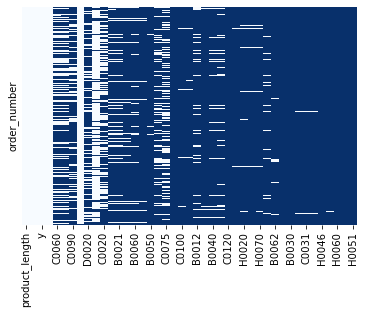

In [38]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

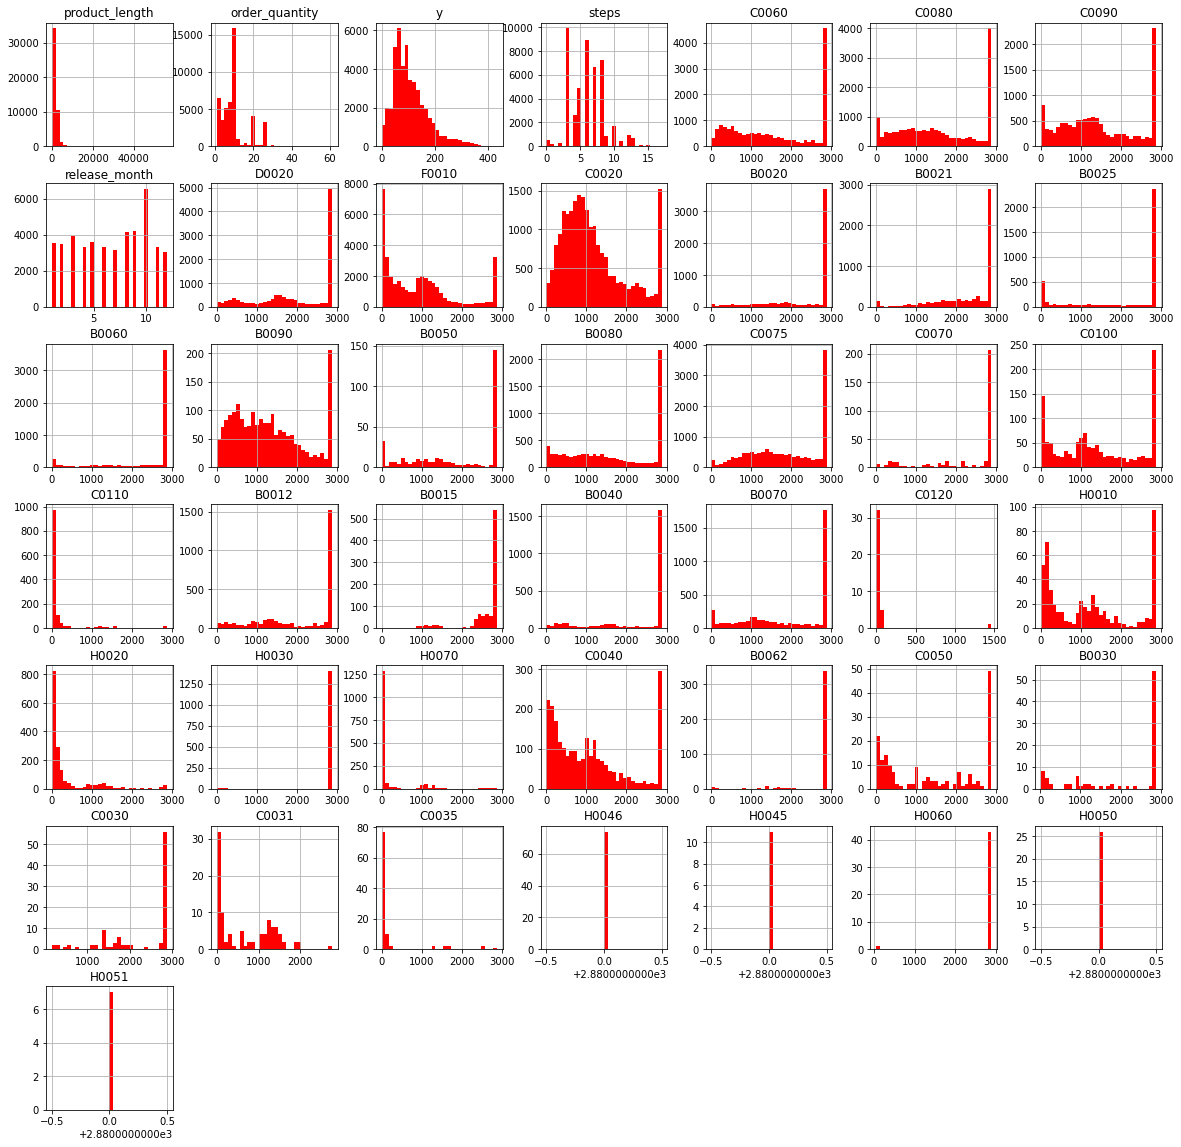

In [40]:
df.hist(bins = 30, figsize = (20,20), color = 'r');
plt.show()

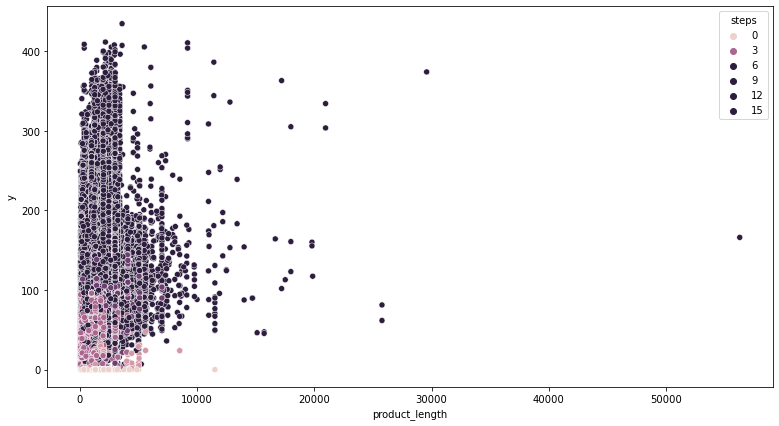

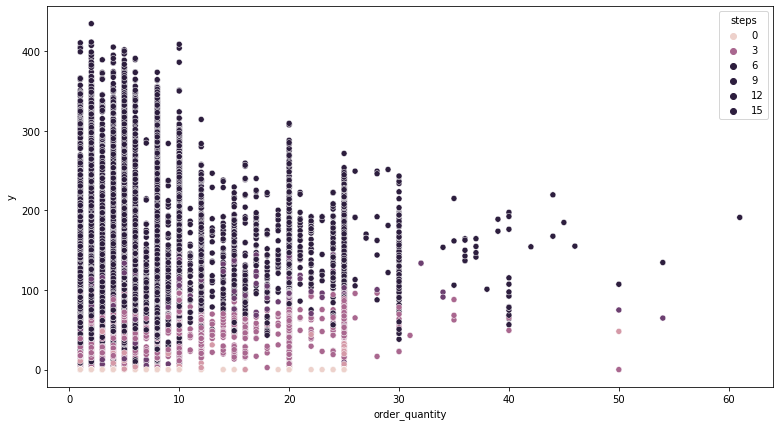

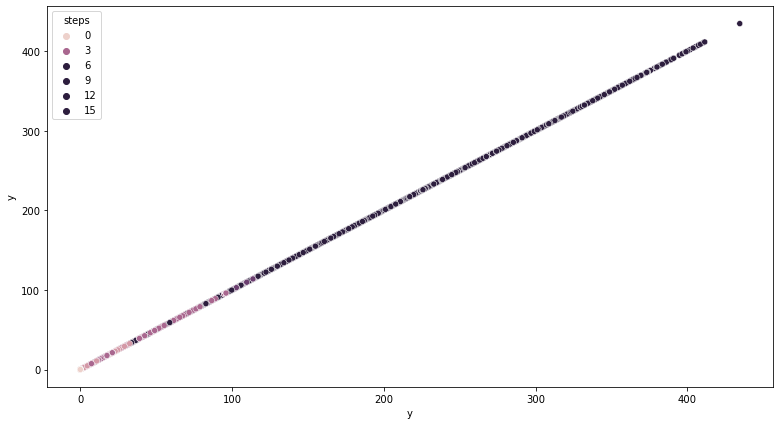

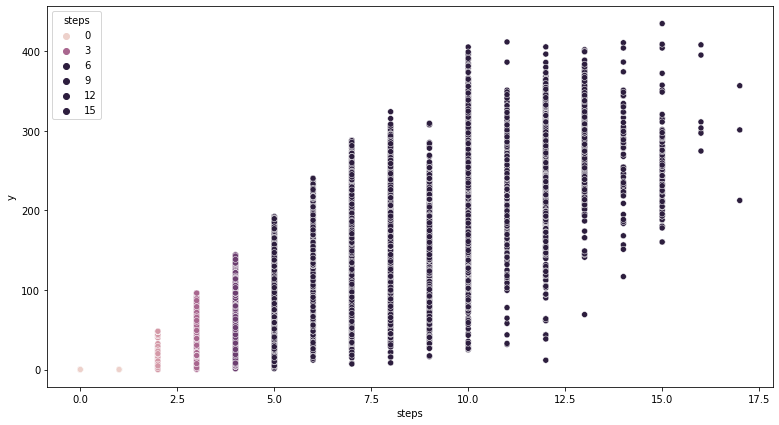

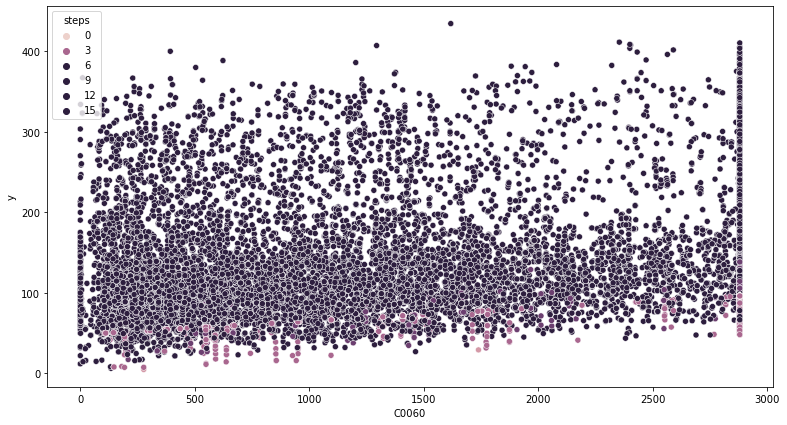

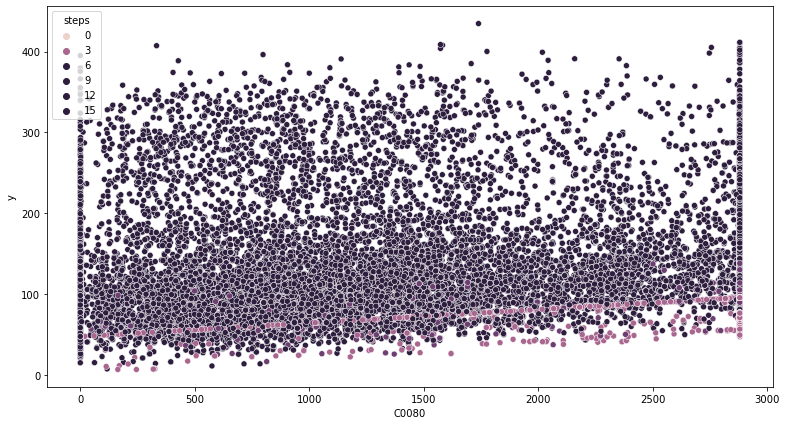

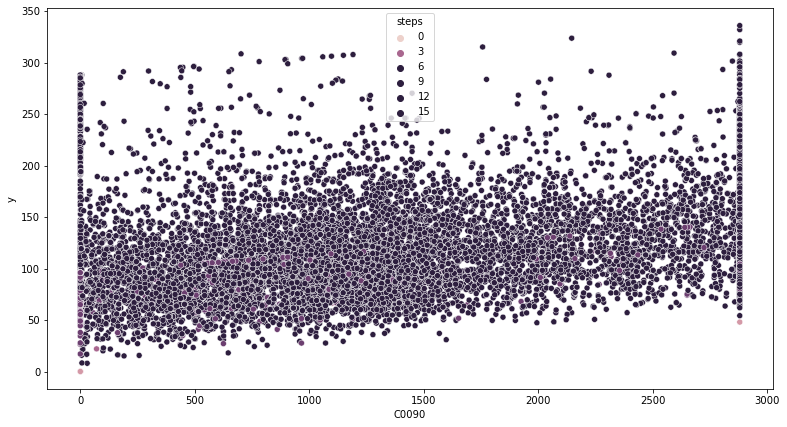

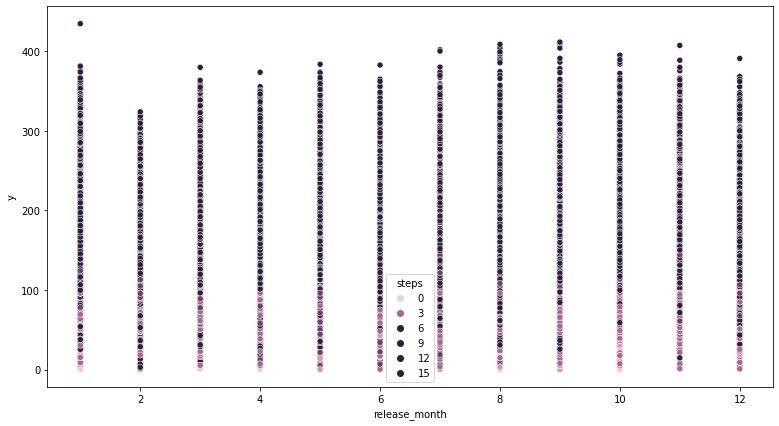

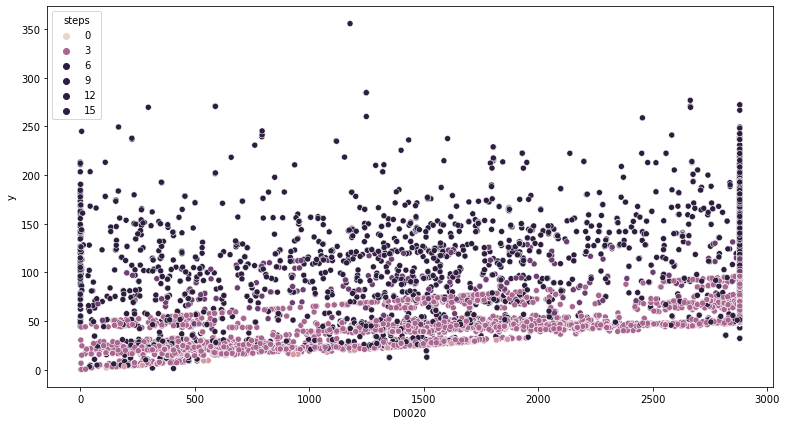

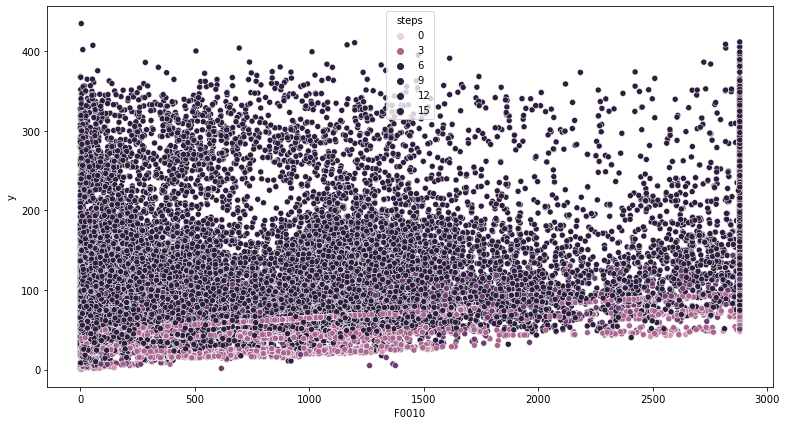

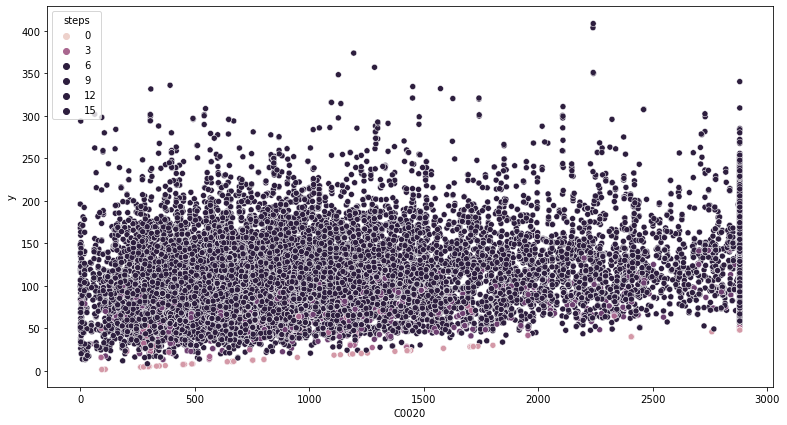

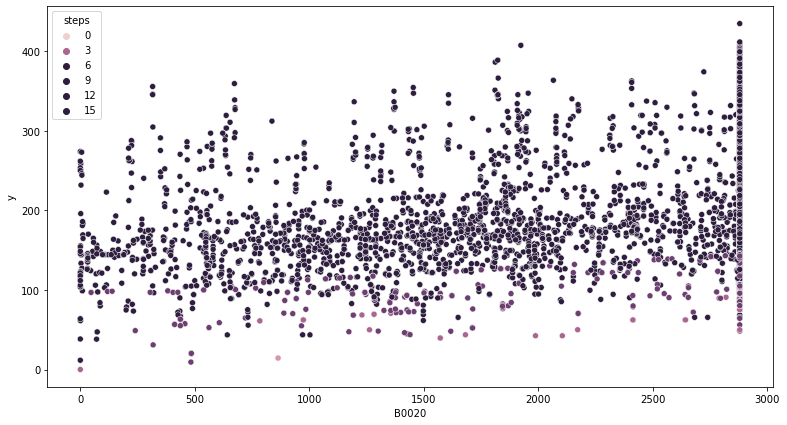

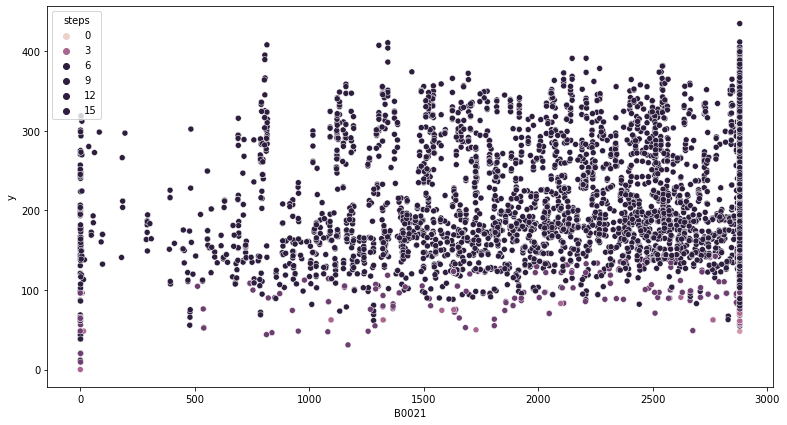

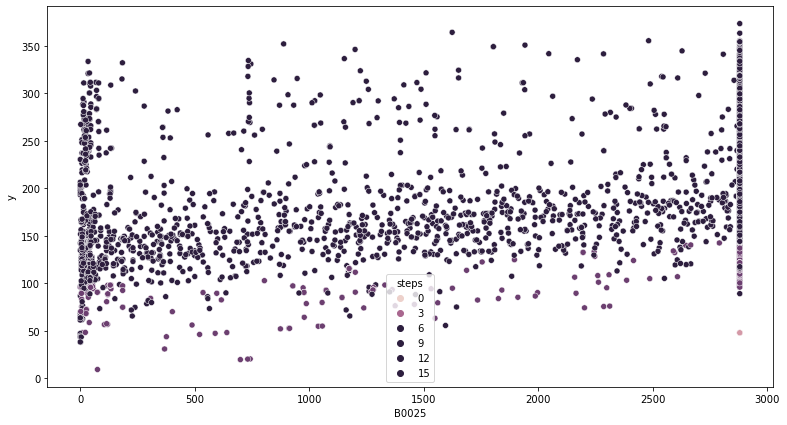

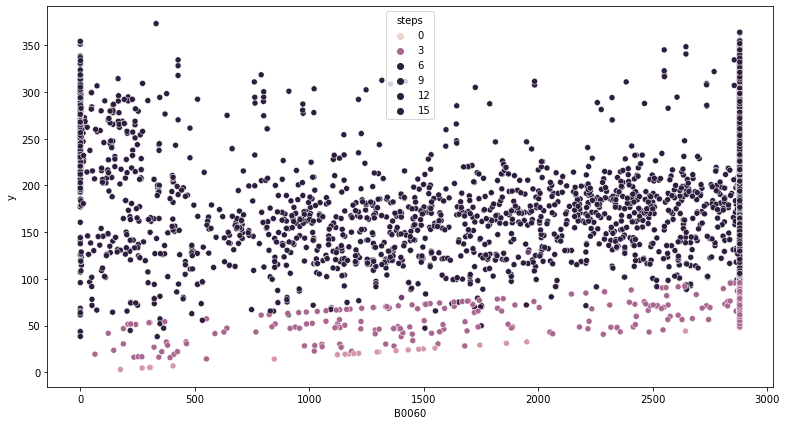

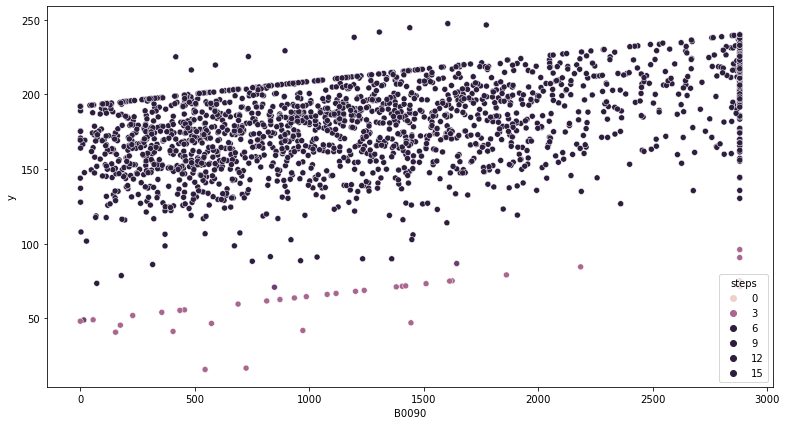

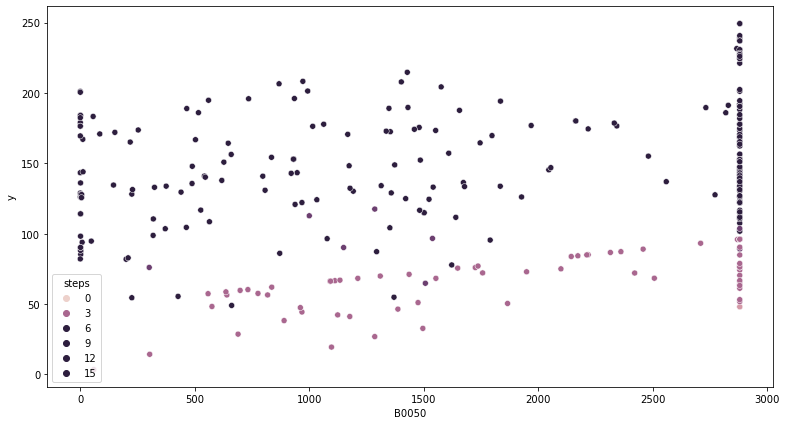

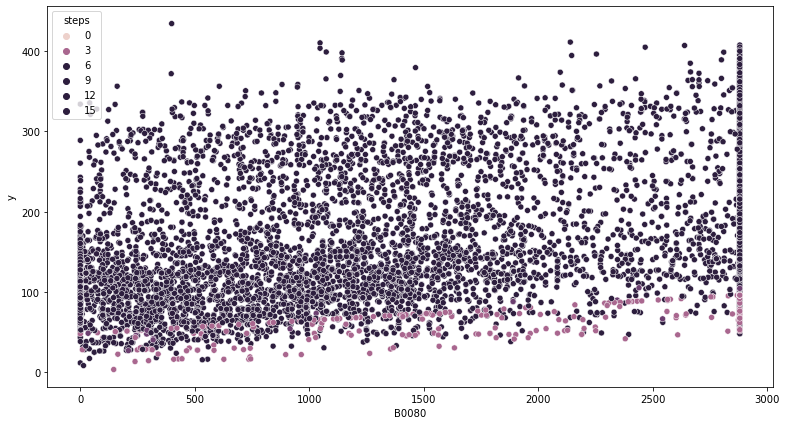

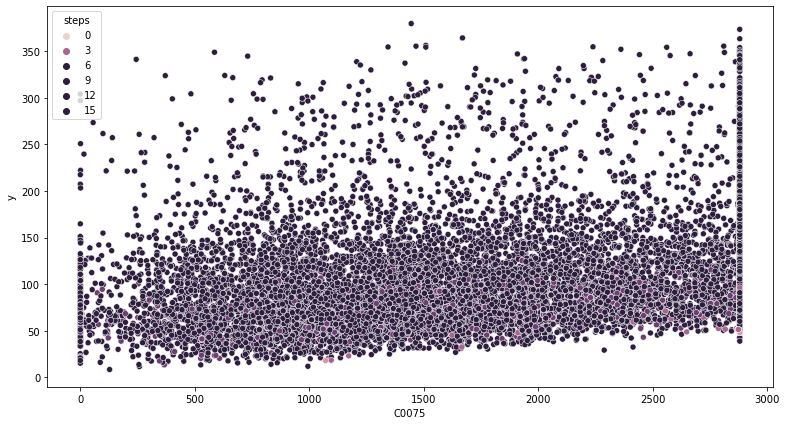

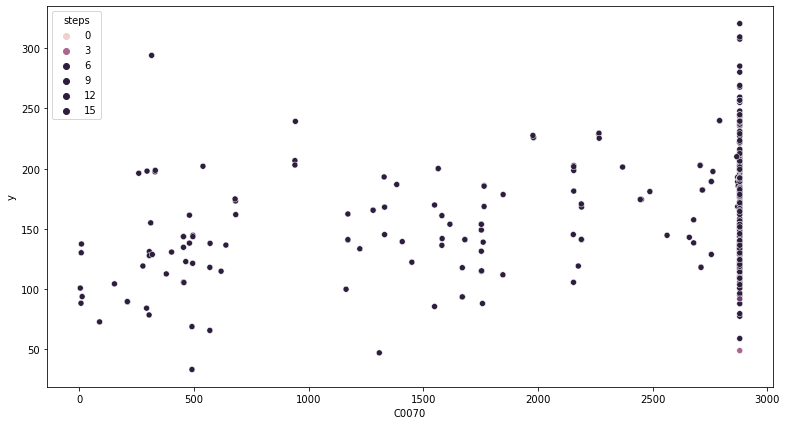

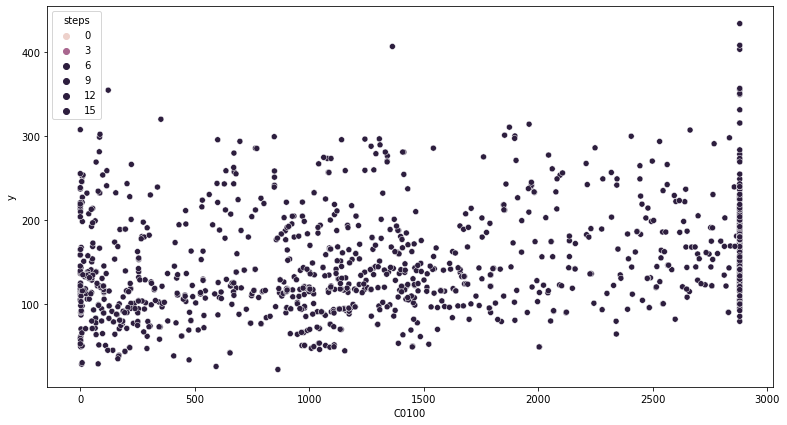

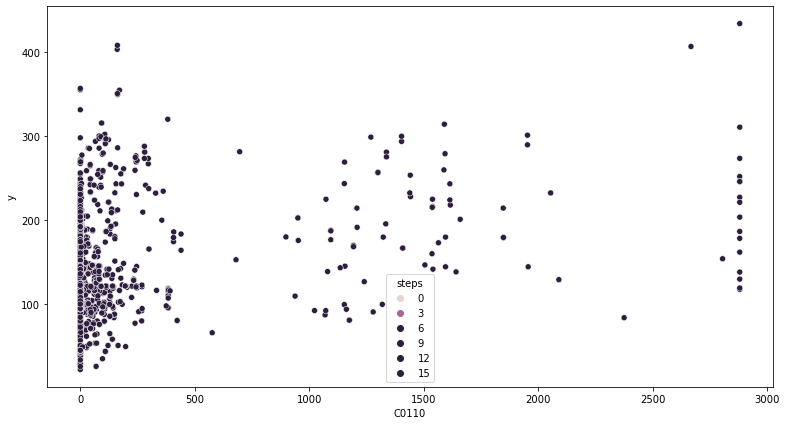

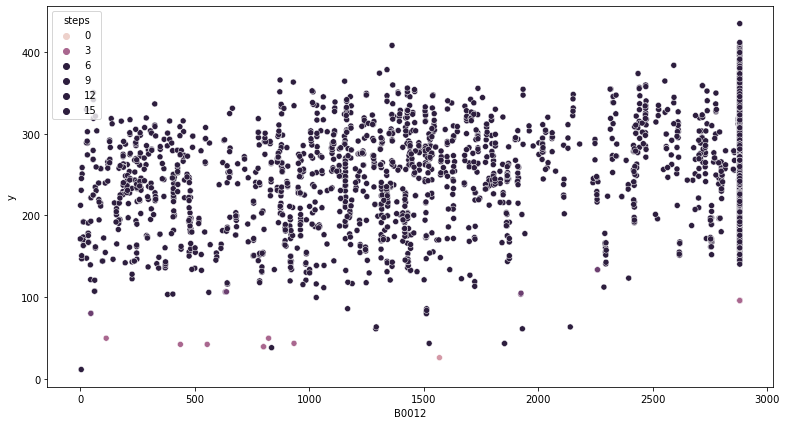

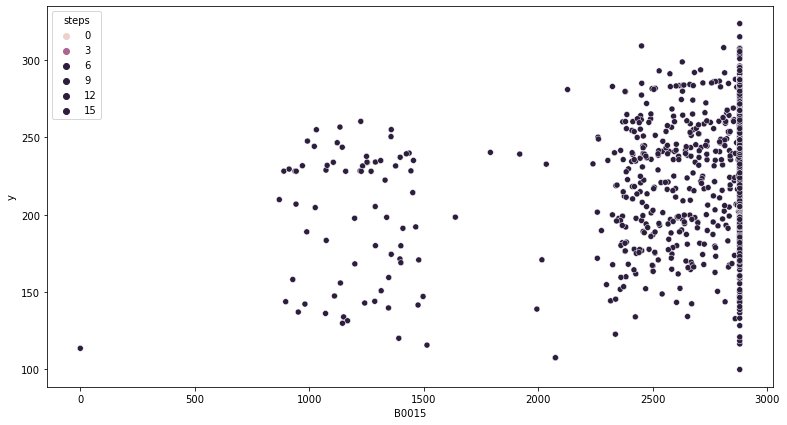

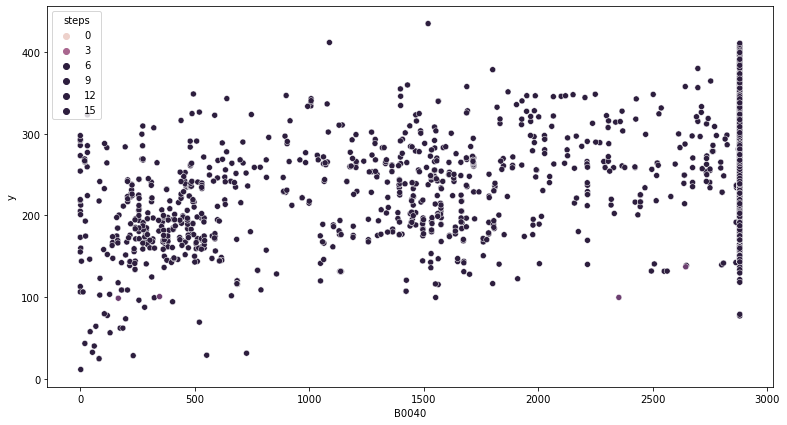

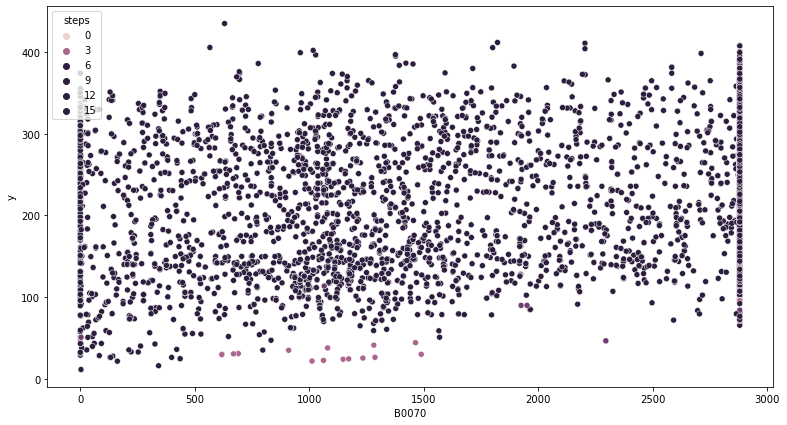

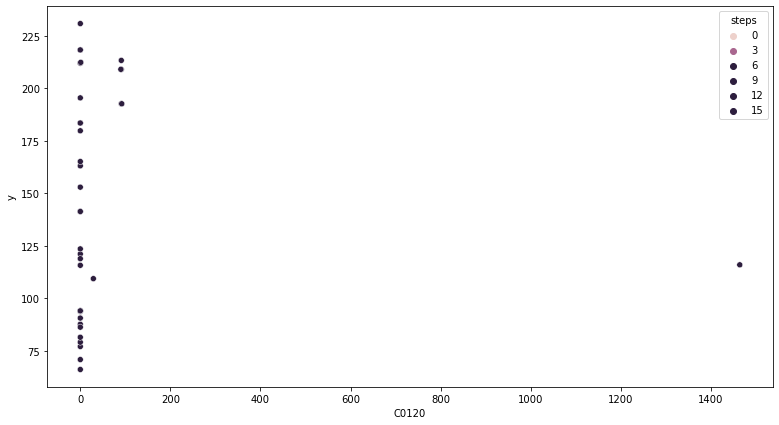

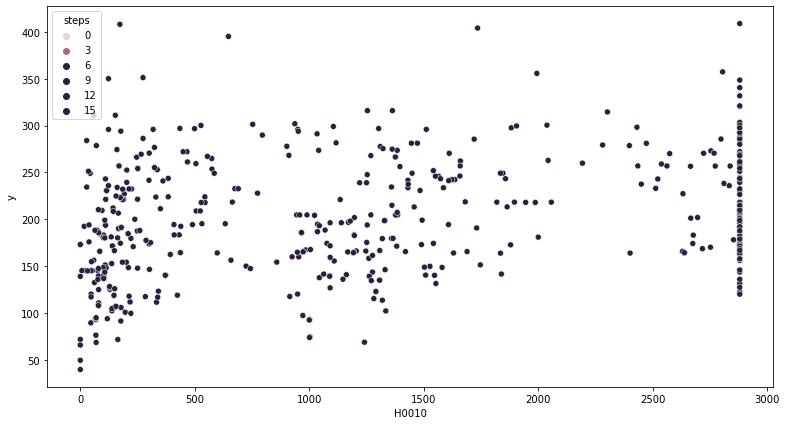

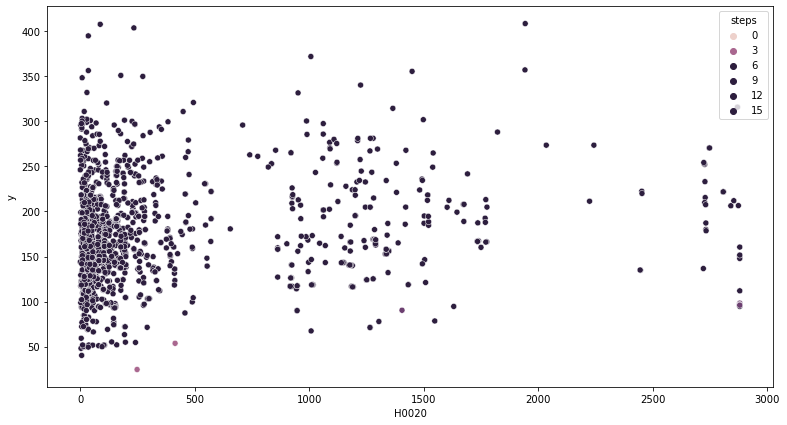

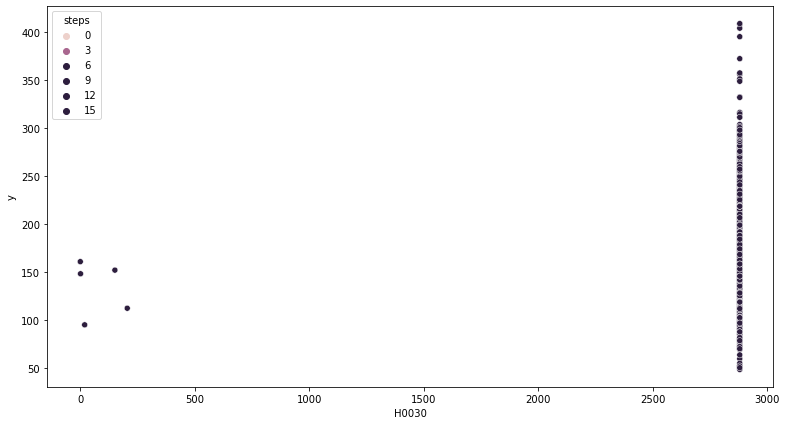

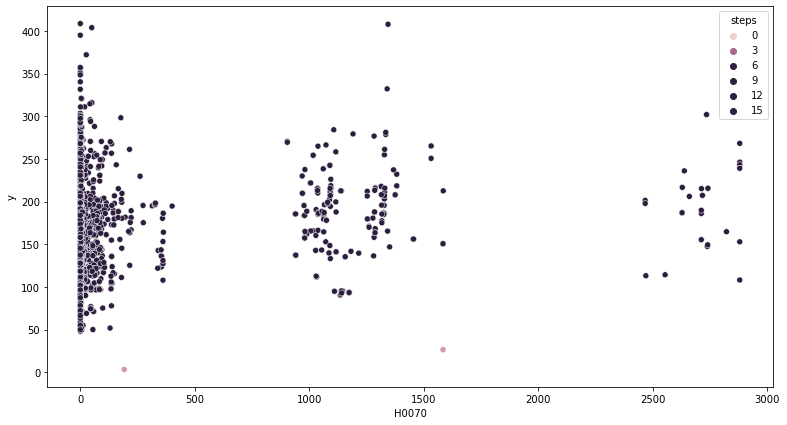

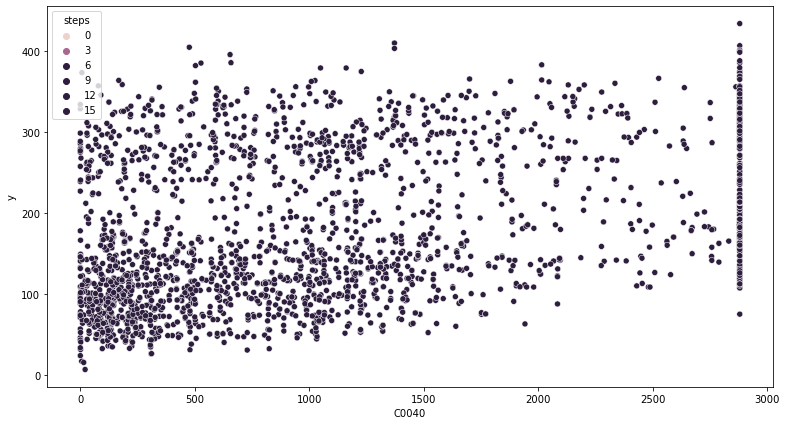

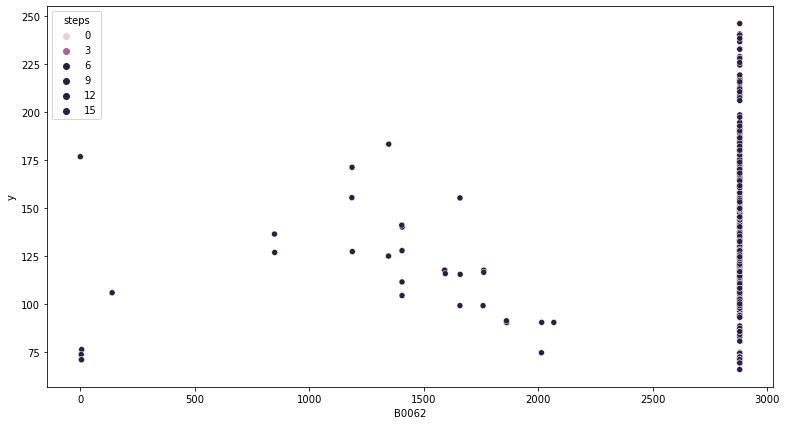

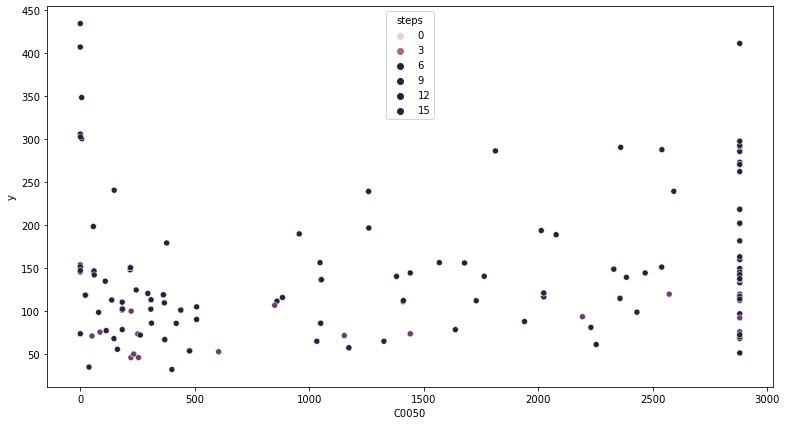

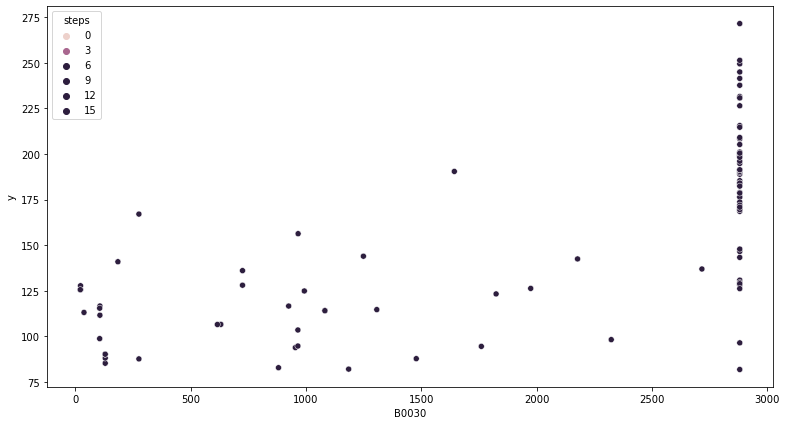

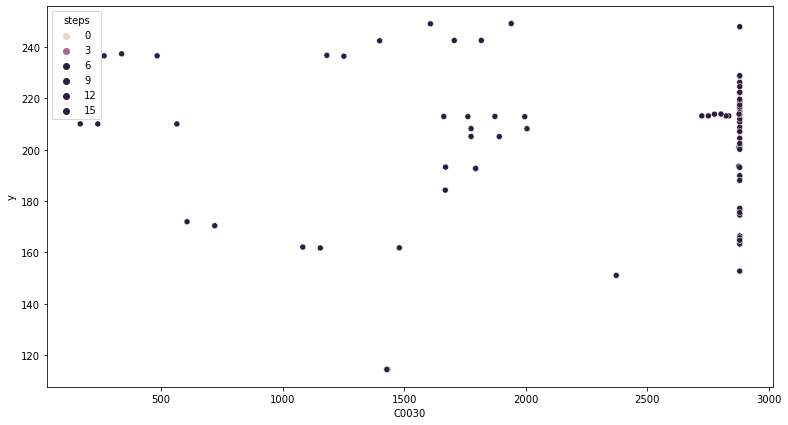

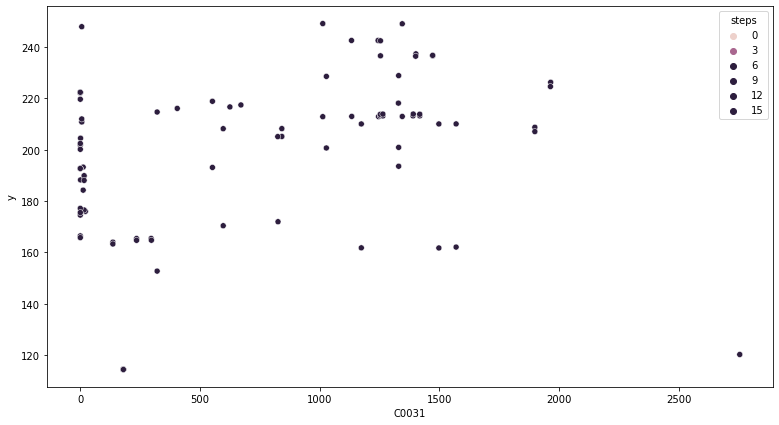

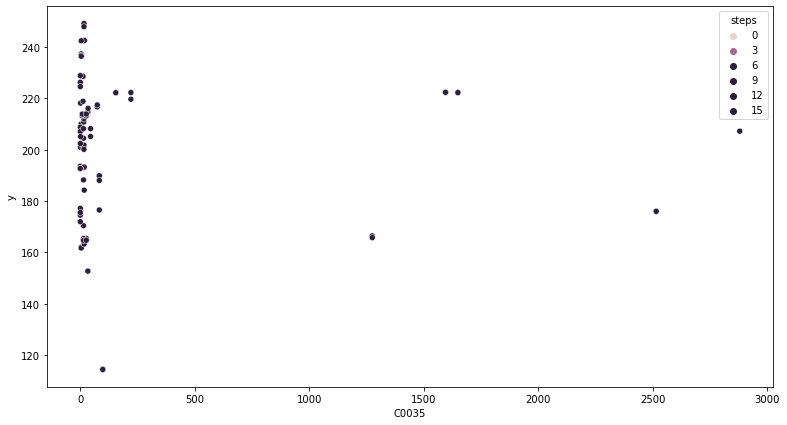

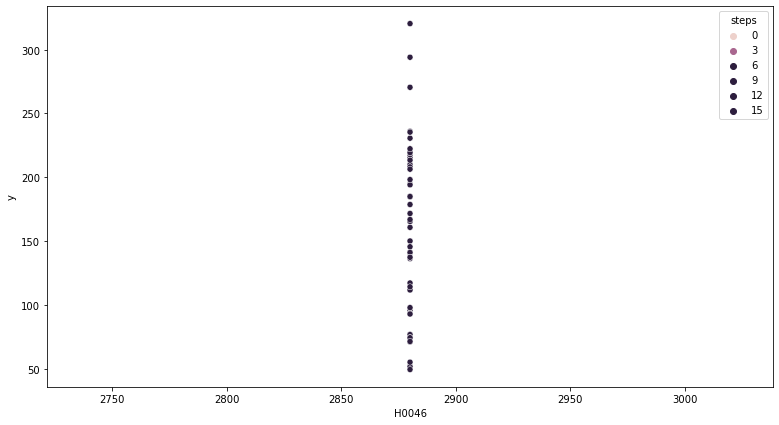

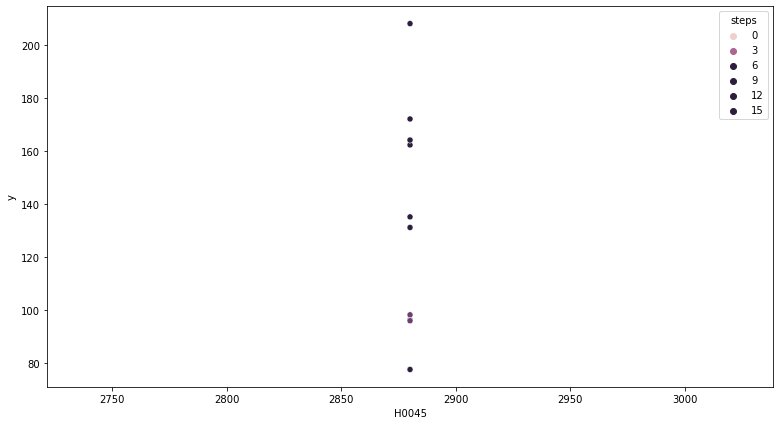

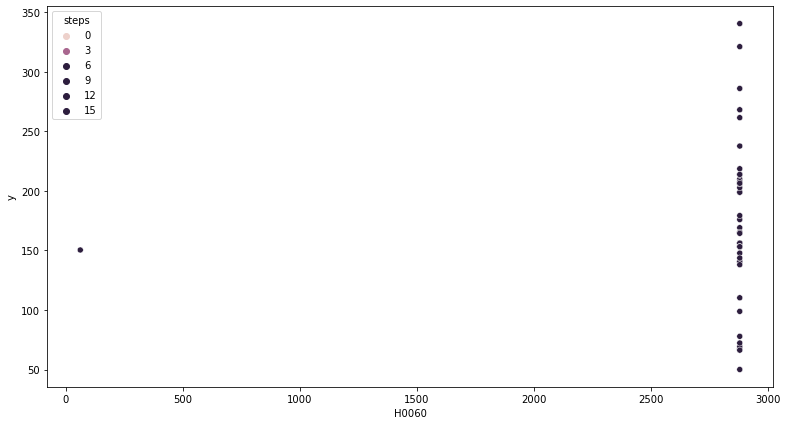

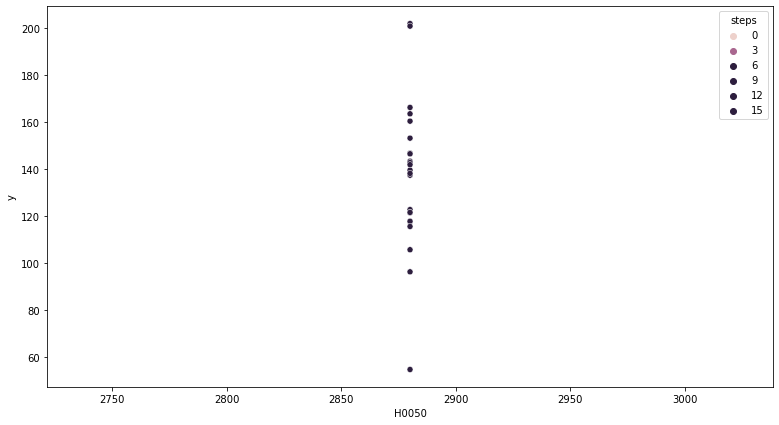

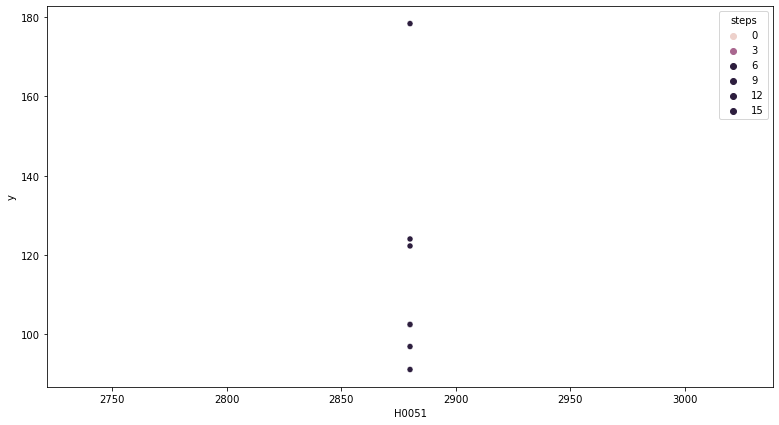

In [6]:
for i in df.columns:    
  plt.figure(figsize = (13, 7))
  sns.scatterplot(x = i, y = 'y', hue = "steps", hue_norm = (1,5), data = df)
  plt.show()

In [25]:
X = df.drop(columns = ['y'])
y = df['y']

X = np.array(X)
y = np.array(y)

y = y.reshape(-1,1)
y.shape

(46087, 1)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [27]:
X_train.shape

(34565, 42)

In [28]:
print(X_test.shape)

(11522, 42)


In [29]:
# scaling the data before training the model
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler_x = StandardScaler()
# X = scaler_x.fit_transform(X)
# scaler_y = StandardScaler()
# y = scaler_y.fit_transform(y)

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [31]:

import xgboost as xgb


model = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 30, n_estimators = 100)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:

result = model.score(X_test, y_test)
print("Accuracy : {}".format(result))

Accuracy : 0.968160243318781


In [33]:
y_predict = model.predict(X_test)


In [34]:
y_predict

array([135.71567 , 114.34192 ,  65.76333 , ...,  47.465878,  85.50578 ,
        60.196156], dtype=float32)

In [35]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
k = X_test.shape[1]
n = len(X_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_predict)),'.3f'))
MSE = mean_squared_error(y_test, y_predict)
MAE = mean_absolute_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 11.693 
MSE = 136.71479654654243 
MAE = 6.306875624783421 
R2 = 0.968160243318781 
Adjusted R2 = 0.9680437462562659


In [ ]:
# volume_df = volume_df.dropna(subset=['product_family', 'product_model'])
### one hot encoding
# volume_df['product_family'] = volume_df['product_family'].astype('category')
# volume_df['product_model'] = volume_df['product_model'].astype('category')
# one_hot_encoded_datab = pd.get_dummies(volume_df, columns = ['product_family', 'product_model']) 
# res = pd.concat([volume_df, one_hot_encoded_datab], axis=1)